# RECOMMENDATION

## Documentation

### Plan

<ol>
    <li>Find/Filter out important metadata for datasets starting with main table</li>
    <li>Data Cleaning</li>
    <li>kNN model to recommend similar datasets from metadata similarity</li>
    <li>kNN model to recommend similar datasets from text similarity</li>
    <li>Ensemble</li>
<ol>

### Notes

<ul>
    <li>IDs other than dataset ID to be excluded from filtered metadata</li>
    <li>Abstract/Keywords/DescriptiveQuestionsTable can be used if NLP methods are applied</li>
    <li>Area, Task, Types are all crucial metadata</li>
    <li>NumInstances, NumAttributes, AttributeTypes are another set of important data</li>
    <li>All features chosen above can be categorical besides NumInstances and NumAttributes</li>
    <li>Some unique values can be combined such as "Life Science" + "Life Sciences" + "Life"</li>
    <li>AttributeTypes has a empty unique value with 48 instances</li>
    <li>Can create binary columns such as Classification, Regression, Clustering, above will be handled</li>
    <li>Numerical values very skewed, bin/quantile techniques</li>
    <li>Autoencoder for DR? Does it assume anything about the data? Didn't work, many mapped to same point</li>
    <li>Are there actually 0 values on these datasets? / model that can find NumAttributes/NumInstances</li>
    <li>No better info for the zero-value instances in tabular/attribute tables, nor better text for nlp</li>
    <li>Might need to drop NumAttributes because of many 0s, in order to provide accurate recommended datasets to all</li>
    <li>For ensemble, we can calculate a context similarity measure and a separate data characteristic measure, and weight them for recommendation, in order to prefer one recommendation type over the other</li>
</ul>

## Code

### Retrieving Data

In [1]:
# Import
import pandas as pd
import sqlite3 as sq3

In [2]:
# Connecting to database
path = 'data/ucimlrepo.db'
con = sq3.Connection(path)

In [3]:
# Checking available tables
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;")
print(cursor.fetchall())

[('attributes',), ('creators',), ('dataset_creators',), ('dataset_keywords',), ('dataset_papers',), ('datasets_old_schema',), ('descriptive_questions',), ('donated_datasets',), ('evals',), ('foreign_papers',), ('keywords',), ('metrics',), ('models',), ('native_papers',), ('slugs',), ('tabular',)]


In [4]:
# Writing and executing query into dataframe
query = '''
SELECT * 
FROM donated_datasets;
'''
df = pd.read_sql(query, con)
df

,ID,userID,introPaperID,Name,Abstract,Area,Task,Types,DOI,DateDonated,...,URLFolder,URLReadme,URLLink,Graphics,Status,NumHits,NumInstances,NumAttributes,AttributeTypes,slug
0,1,1,NaN,Abalone,Predict the age of abalone from physical measu...,Life,Classification,Multivariate,None,1995-12-01,...,../machine-learning-databases/abalone/,../machine-learning-databases/abalone/abalone....,None,None,APPROVED,46870,4177,9,"Categorical, Integer, Real",abalone
1,2,1,NaN,Adult,Predict whether income exceeds $50K/yr based o...,Social,Classification,Multivariate,None,1996-05-01,...,../machine-learning-databases/adult/,../machine-learning-databases/adult/adult.names,None,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,85922,48842,15,"Categorical, Integer",adult
2,3,1,NaN,Annealing,Steel annealing data,Physical,Classification,Multivariate,None,None,...,../machine-learning-databases/annealing/,../machine-learning-databases/annealing/anneal...,None,None,APPROVED,11850,798,38,"Categorical, Integer, Real",annealing
3,4,1,NaN,Anonymous Microsoft Web Data,Log of anonymous users of www.microsoft.com; p...,Computer,Recommender-Systems,None,None,1998-11-01,...,../machine-learning-databases/anonymous/,../machine-learning-databases/anonymous/anonym...,None,None,APPROVED,16320,37711,0,Categorical,anonymous+microsoft+web+data
4,5,1,NaN,Arrhythmia,Distinguish between the presence and absence o...,Life,Classification,Multivariate,None,1998-01-01,...,../machine-learning-databases/arrhythmia/,../machine-learning-databases/arrhythmia/arrhy...,None,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,15391,452,279,"Categorical, Integer, Real",arrhythmia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,696,19,2291.0,Open Web Text Corpus,We started by extracting all Reddit post urls ...,Other,"Classification, Regression, Clustering",Text,None,2021-12-03,...,None,None,https://skylion007.github.io/OpenWebTextCorpus/,None,APPROVED,1250,8013769,0,None,open+web+text+corpus
598,697,461,2292.0,Predict students' dropout and academic success,A dataset created from a higher education inst...,Other,Classification,Tabular,1,2021-12-13,...,/ml/datasets/697,None,None,/ml/datasets/697/Graphics,APPROVED,2827,4424,0,None,predict+students+dropout+and+academic+success
599,713,620,2303.0,Auction Verification,We modeled a simultaneous multi-round auction ...,Computer Science,"Classification, Regression",Tabular,None,2022-03-01,...,/ml/datasets/713,None,None,None,APPROVED,703,2043,0,None,auction+verification
600,715,578,2305.0,LT-FS-ID: Intrusion detection in WSNs,There exist five columns in this dataset. The ...,Computer Science,Regression,Tabular,https://doi.org/10.3390/s22031070,2022-03-09,...,/ml/datasets/715,None,None,/ml/datasets/715/Graphics,APPROVED,273,182,0,None,lt+fs+id+intrusion+detection+in+wsns


### Data Exploration

In [5]:
# Imports
import matplotlib.pyplot as plt

In [6]:
# Number of unique values per column
columns = ['ID', 'Area', 'Task', 'Types', 'NumInstances', 'NumAttributes', 'AttributeTypes']
df.drop(df.columns.difference(columns), axis=1, inplace=False).nunique()

ID                602
Area               14
Task               23
Types              43
NumInstances      480
NumAttributes     108
AttributeTypes      9
dtype: int64

In [7]:
categorical_features = ['Area', 'Task', 'Types', 'AttributeTypes']

In [8]:
# Unique values and counts per column
for col in categorical_features:
    print(f'Column: {col}')
    print(df[col].value_counts())
    print()

Column: Area
Computer             214
Life                 135
Other                 80
Physical              57
Business              42
Social                38
Game                  11
Computer Science       7
Financial              5
Engineering            4
Multivariate           2
Computer Security      1
Life Sciences          1
Life Science           1
Name: Area, dtype: int64

Column: Task
Classification                                                                                                      314
Regression                                                                                                           64
Classification, Clustering                                                                                           63
Classification, Regression                                                                                           42
Classification, Regression, Clustering                                                                               2

(array([585.,   8.,   6.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([       0.,  6300000., 12600000., 18900000., 25200000., 31500000.,
        37800000., 44100000., 50400000., 56700000., 63000000.]),
 <BarContainer object of 10 artists>)

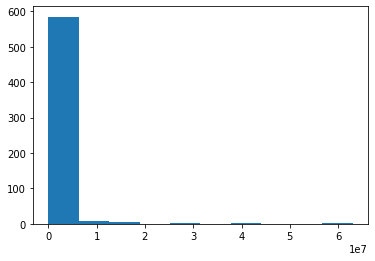

In [9]:
plt.hist(df['NumInstances']) 

(array([573.,  12.,   1.,  11.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([   0. ,  155.9,  311.8,  467.7,  623.6,  779.5,  935.4, 1091.3,
        1247.2, 1403.1, 1559. ]),
 <BarContainer object of 10 artists>)

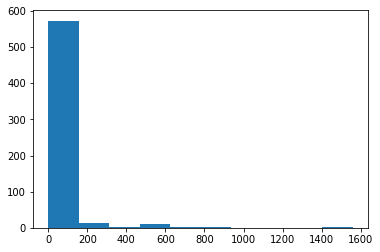

In [10]:
plt.hist(df['NumAttributes'])

(array([537.,  43.,   9.,   4.,   2.,   2.,   3.,   1.,   0.,   1.]),
 array([5.000000e+00, 1.305210e+04, 2.609920e+04, 3.914630e+04,
        5.219340e+04, 6.524050e+04, 7.828760e+04, 9.133470e+04,
        1.043818e+05, 1.174289e+05, 1.304760e+05]),
 <BarContainer object of 10 artists>)

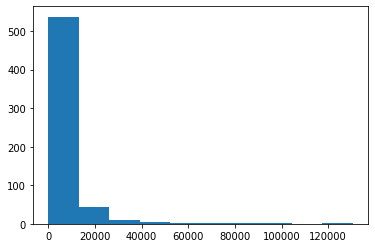

In [11]:
plt.hist(df['NumHits'])

In [12]:
# Number of zeros
print(f"NumInstances: {df[df['NumInstances'] == 0].shape[0]}, NumAttributes: {df[df['NumAttributes'] == 0].shape[0]}")

NumInstances: 37, NumAttributes: 296


In [13]:
df[df['NumInstances']==0]

,ID,userID,introPaperID,Name,Abstract,Area,Task,Types,DOI,DateDonated,...,URLFolder,URLReadme,URLLink,Graphics,Status,NumHits,NumInstances,NumAttributes,AttributeTypes,slug
20,21,1,NaN,Chess (King-Rook vs. King-Knight),Knight Pin Chess End-Game Database Creator,Game,Classification,"Multivariate, Data-Generator",None,1988-10-03,...,../machine-learning-databases/chess/king-rook-...,../machine-learning-databases/chess/king-rook-...,None,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,11092,0,22,"Categorical, Integer",chess+king+rook+vs+king+knight
23,24,1,NaN,Chess (Domain Theories),6 different domain theories for generating leg...,Game,None,Domain-Theory,None,None,...,../machine-learning-databases/chess/domain-the...,../machine-learning-databases/chess/domain-the...,None,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,6237,0,0,None,chess+domain+theories
33,34,1,NaN,Diabetes,This diabetes dataset is from AIM '94,Life,None,"Multivariate, Time-Series",None,None,...,../machine-learning-databases/diabetes/,../machine-learning-databases/diabetes/README,None,None,APPROVED,89257,0,0,"Categorical, Integer",diabetes
34,35,1,NaN,DGP2 - The Second Data Generation Program,Generates application domains based on specifi...,Other,None,Data-Generator,None,None,...,../machine-learning-databases/dgp-2/,../machine-learning-databases/dgp-2/DGP-2.names,None,None,APPROVED,40,0,0,Real,dgp2+the+second+data+generation+program
35,36,1,NaN,Document Understanding,"Five concepts, expressed as predicates, to be ...",Other,None,None,None,1994-11-01,...,../machine-learning-databases/document-underst...,../machine-learning-databases/document-underst...,None,None,APPROVED,46,0,0,None,document+understanding
36,37,1,NaN,EBL Domain Theories,Assorted small-scale domain theories,Computer,None,None,None,None,...,../machine-learning-databases/ebl/,../machine-learning-databases/ebl/README,None,None,APPROVED,30,0,0,None,ebl+domain+theories
47,49,1,NaN,ICU,Data set prepared for the use of participants ...,Life,None,"Multivariate, Time-Series",None,None,...,../machine-learning-databases/icu/,../machine-learning-databases/icu/README,None,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,118,0,0,Real,icu
55,57,1,NaN,LED Display Domain,From Classification and Regression Trees book;...,Computer,Classification,"Multivariate, Data-Generator",None,1988-11-10,...,../machine-learning-databases/led-display-crea...,../machine-learning-databases/led-display-crea...,None,None,APPROVED,10513,0,7,Categorical,led+display+domain
59,61,1,NaN,Logic Theorist,All code for Logic Theorist,Computer,None,Domain-Theory,None,None,...,../machine-learning-databases/logic-theorist/,../machine-learning-databases/logic-theorist/R...,None,None,APPROVED,35,0,0,None,logic+theorist
64,66,1,NaN,Mobile Robots,Learning concepts from sensor data of a mobile...,Computer,None,Domain-Theory,None,1995-07-15,...,../machine-learning-databases/mobile-robots/,../machine-learning-databases/mobile-robots/mo...,None,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,7293,0,0,"Categorical, Integer, Real",mobile+robots


### Data Cleaning

In [14]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler

In [15]:
class FilterFeatures(BaseEstimator, TransformerMixin):
    '''
    Drops attributes that won't be used
    '''
    def __init__(self):
        self.id = ['ID']
        self.categorical_features =  ['Area', 'Task', 'Types', 'AttributeTypes']
        self.numerical_features = ['NumInstances', 'NumHits']
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return X.drop(X.columns.difference(self.id+self.categorical_features+self.numerical_features), axis=1, inplace=False)

In [16]:
class AreaEncoding(BaseEstimator, TransformerMixin):
    '''
    Merges similar Areas together and creates one-hot-encoding of Areas
    '''
    def __init__(self):
        self.cols = {
            'Life': {'Life'},
            'Computer': {'Computer'},
            'Finance & Business': {'Finance', 'Business'},
            'Physical & Engineering': {'Physical', 'Engineering'},
            'Games': {'Games'},
            'Social': {'Social'},
            }
            
    def fit(self, X):
        return self
    
    def transform(self, data):
        X = data.copy()
        for col, matches in self.cols.items():
            condition = ''
            for match in matches:
                condition += "data['Area'].str.match(match)" + '|'
            condition += 'False'
            
            X['Area_' + col] = np.where(eval(condition), 1, 0)
        X.drop(columns=['Area'], inplace=True)
        
        return X

In [17]:
class TaskEncoding(BaseEstimator, TransformerMixin):
    '''
    Creates binary features that detail whether a Task is present, not one-hot-encoding
    '''
    def __init__(self):
        self.cols = {
            'Classification',
            'Clustering',
            'Regression',
            'Caus',
            }
            
    def fit(self, X):
        return self
    
    def transform(self, data):
        X = data.copy()
        for col in self.cols:
            X['Task_' + col] = np.where(data['Task'].str.match(col), 1, 0)
        X.drop(columns=['Task'], inplace=True)
        
        return X

In [18]:
class TypesEncoding(BaseEstimator, TransformerMixin):
    '''
    Creates binary features that detail whether a Type is present, not one-hot-encoding
    '''
    def __init__(self):
        self.cols = {
            'Multivariate',
            'Time-Series',
            'Sequential',
            'Domain-Theory',
            'Univariate',
            'Text',
            'Image',
            'Tabular',
            'Generator',
            'Relational',
            }
            
    def fit(self, X):
        return self
    
    def transform(self, data):
        X = data.copy()
        for col in self.cols:
            X['Types_' + col] = np.where(data['Types'].str.match(col), 1, 0)
        X.drop(columns=['Types'], inplace=True)
        
        return X

In [19]:
class AttributeTypesEncoding(BaseEstimator, TransformerMixin):
    '''
    Creates binary features that detail whether an AttributeType is present, not one-hot-encoding
    '''
    def __init__(self):
        self.cols = {
            'Integer',
            'Real',
            'Categorical',
            }
            
    def fit(self, X):
        return self
    
    def transform(self, data):
        X = data.copy()
        for col in self.cols:
            X['AttributeTypes_' + col] = np.where(X['AttributeTypes'].str.match(col), 1, 0)
        X.drop(columns=['AttributeTypes'], inplace=True)
            
        return X

In [20]:
df['NumInstances']

0         4177
1        48842
2          798
3        37711
4          452
        ...   
597    8013769
598       4424
599       2043
600        182
601      29333
Name: NumInstances, Length: 602, dtype: int64

In [21]:
class NumInstancesEncoding(BaseEstimator, TransformerMixin):
    '''
    Bins NumInstances into quantile ranges, then gives labels between 0 and 1
    '''
    def __init__(self):
        self.q = list(np.arange(0, 1.005, 0.005))
            
    def fit(self, X):
        return self
    
    def transform(self, data):
        X = data.copy()
        _, bins = pd.qcut(X['NumInstances'], q=self.q, duplicates='drop', retbins=True)
        
        labels = np.arange(0, 1+1/len(bins), 1/len(bins))[1:]
        for i in range(len(bins)-1):
            start, end = bins[i], bins[i+1]
            x = X['NumInstances']
            X.loc[:, 'NumInstances'] = x.where(~( (x > start) & (x <= end) ), labels[i])
        return X

In [22]:
class NumHitsEncoding(BaseEstimator, TransformerMixin):
    '''
    Bins NumHits into quantile ranges, then gives labels between 0 and 1
    '''
    def __init__(self):
        self.q = list(np.arange(0, 1.005, 0.005))
            
    def fit(self, X):
        return self
    
    def transform(self, data):
        X = data.copy()
        _, bins = pd.qcut(X['NumHits'], q=self.q, duplicates='drop', retbins=True)
        
        labels = np.arange(0, 1+1/len(bins), 1/len(bins))[1:]
        for i in range(len(bins)-1):
            start, end = bins[i], bins[i+1]
            x = X['NumHits']
            X.loc[:, 'NumHits'] = x.where(~( (x > start) & (x <= end) ), labels[i])
        return X

In [23]:
# Pipeline to process raw dataframe
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
                    ('filter_features', FilterFeatures()),
                    ('Area_merged_to_binary', AreaEncoding()),
                    ('Task_to_binary', TaskEncoding()),
                    ('Types_to_binary', TypesEncoding()),
                    ('AttributeTypes_to_binary', AttributeTypesEncoding()),
                    ('NumInstances_bins', NumInstancesEncoding()),
                    ('NumHits_bins', NumHitsEncoding()),
                    ])

In [24]:
# Cleaned data ready to start applying models
data = preprocess_pipeline.fit_transform(df)
data

,ID,NumHits,NumInstances,Area_Life,Area_Computer,Area_Finance & Business,Area_Physical & Engineering,Area_Games,Area_Social,Task_Clustering,...,Types_Time-Series,Types_Univariate,Types_Sequential,Types_Tabular,Types_Image,Types_Domain-Theory,Types_Multivariate,AttributeTypes_Categorical,AttributeTypes_Real,AttributeTypes_Integer
0,1,0.985075,0.582011,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,2,0.995025,0.820106,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
2,3,0.875622,0.391534,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,4,0.920398,0.798942,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,0.910448,0.296296,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,696,0.751244,0.973545,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,697,0.791045,0.587302,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
599,713,0.686567,0.507937,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
600,715,0.487562,0.153439,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Modeling

### Recommendation

In [25]:
# Imports
from sklearn.neighbors import NearestNeighbors

In [26]:
# Changing data to numpy for sklearn model
X = data.to_numpy()
ID = X[:, 0]
X = X[:, 1:]
X

array([[0.98507463, 0.58201058, 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.99502488, 0.82010582, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.87562189, 0.39153439, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.68656716, 0.50793651, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48756219, 0.15343915, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05472637, 0.78306878, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [27]:
# Model
nbrs = NearestNeighbors(n_neighbors=4).fit(X)

In [28]:
# Getting nearest neighbors
distances, indices = nbrs.kneighbors(X)
distances, indices

(array([[0.        , 0.06522276, 0.07424096, 0.14686407],
        [0.        , 0.0199005 , 0.11692035, 0.16382417],
        [0.        , 0.07952086, 0.37962672, 1.00171997],
        ...,
        [0.        , 0.12616588, 0.6891448 , 1.00857047],
        [0.        , 1.08900897, 1.16868495, 1.45163229],
        [0.        , 0.56746652, 0.6891448 , 1.04136931]]),
 array([[  0,  99,  71,  29],
        [  1,  19,  74, 114],
        [  2,  31,  85, 140],
        ...,
        [599, 596, 601, 598],
        [600, 554, 594, 587],
        [601, 596, 599, 523]], dtype=int64))

In [29]:
# The IDs of the nearest neighbor indices for each row
ID[indices].astype(int)

array([[  1, 102,  73,  30],
       [  2,  20,  76, 117],
       [  3,  32,  88, 143],
       ...,
       [713, 695, 722, 697],
       [715, 574, 692, 607],
       [722, 695, 713, 543]])

In [30]:
# Getting recommendations in dataframe
cols = ['recommendation_1', 'recommendation_2', 'recommendation_3', 'recommendation_4']
rec = pd.DataFrame(ID[indices].astype(int), columns=cols)
rec

,recommendation_1,recommendation_2,recommendation_3,recommendation_4
0,1,102,73,30
1,2,20,76,117
2,3,32,88,143
3,4,123,126,66
4,5,33,47,83
...,...,...,...,...
597,696,570,331,575
598,697,713,695,690
599,713,695,722,697
600,715,574,692,607


In [31]:
# New database with 3 recommedations each row
donated_datasets = df.join(rec)

In [32]:
# Making sure itself is not recommended
for i in range(1, 4):
    fix_indices = donated_datasets.loc[donated_datasets['ID'] == donated_datasets[f'recommendation_{i}']].index.to_list()
    donated_datasets.loc[fix_indices, f'recommendation_{i}'] = donated_datasets.loc[fix_indices, 'recommendation_4']
donated_datasets.drop(columns=['recommendation_4'], inplace=True)
donated_datasets

,ID,userID,introPaperID,Name,Abstract,Area,Task,Types,DOI,DateDonated,...,Graphics,Status,NumHits,NumInstances,NumAttributes,AttributeTypes,slug,recommendation_1,recommendation_2,recommendation_3
0,1,1,NaN,Abalone,Predict the age of abalone from physical measu...,Life,Classification,Multivariate,None,1995-12-01,...,None,APPROVED,46870,4177,9,"Categorical, Integer, Real",abalone,30,102,73
1,2,1,NaN,Adult,Predict whether income exceeds $50K/yr based o...,Social,Classification,Multivariate,None,1996-05-01,...,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,85922,48842,15,"Categorical, Integer",adult,117,20,76
2,3,1,NaN,Annealing,Steel annealing data,Physical,Classification,Multivariate,None,None,...,None,APPROVED,11850,798,38,"Categorical, Integer, Real",annealing,143,32,88
3,4,1,NaN,Anonymous Microsoft Web Data,Log of anonymous users of www.microsoft.com; p...,Computer,Recommender-Systems,None,None,1998-11-01,...,None,APPROVED,16320,37711,0,Categorical,anonymous+microsoft+web+data,66,123,126
4,5,1,NaN,Arrhythmia,Distinguish between the presence and absence o...,Life,Classification,Multivariate,None,1998-01-01,...,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,15391,452,279,"Categorical, Integer, Real",arrhythmia,83,33,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,696,19,2291.0,Open Web Text Corpus,We started by extracting all Reddit post urls ...,Other,"Classification, Regression, Clustering",Text,None,2021-12-03,...,None,APPROVED,1250,8013769,0,None,open+web+text+corpus,575,570,331
598,697,461,2292.0,Predict students' dropout and academic success,A dataset created from a higher education inst...,Other,Classification,Tabular,1,2021-12-13,...,/ml/datasets/697/Graphics,APPROVED,2827,4424,0,None,predict+students+dropout+and+academic+success,690,713,695
599,713,620,2303.0,Auction Verification,We modeled a simultaneous multi-round auction ...,Computer Science,"Classification, Regression",Tabular,None,2022-03-01,...,None,APPROVED,703,2043,0,None,auction+verification,697,695,722
600,715,578,2305.0,LT-FS-ID: Intrusion detection in WSNs,There exist five columns in this dataset. The ...,Computer Science,Regression,Tabular,https://doi.org/10.3390/s22031070,2022-03-09,...,/ml/datasets/715/Graphics,APPROVED,273,182,0,None,lt+fs+id+intrusion+detection+in+wsns,607,574,692


In [33]:
# Getting same DataFrame as above except replacing IDs with Names
dd_names = donated_datasets.set_index('ID', inplace=False)
for i in range(1, 4):
    indices = dd_names[f'recommendation_{i}'].to_list()
    dd_names.loc[:, f'recommendation_{i}'] = dd_names.loc[indices]['Name'].to_list()

In [34]:
dd_names

,userID,introPaperID,Name,Abstract,Area,Task,Types,DOI,DateDonated,isTabular,...,Graphics,Status,NumHits,NumInstances,NumAttributes,AttributeTypes,slug,recommendation_1,recommendation_2,recommendation_3
ID,,,,,,,,,,,,,,,,,,,,,
1,1,NaN,Abalone,Predict the age of abalone from physical measu...,Life,Classification,Multivariate,None,1995-12-01,1,...,None,APPROVED,46870,4177,9,"Categorical, Integer, Real",abalone,Contraceptive Method Choice,Thyroid Disease,Mushroom
2,1,NaN,Adult,Predict whether income exceeds $50K/yr based o...,Social,Classification,Multivariate,None,1996-05-01,1,...,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,85922,48842,15,"Categorical, Integer",adult,Census-Income (KDD),Census Income,Nursery
3,1,NaN,Annealing,Steel annealing data,Physical,Classification,Multivariate,None,None,1,...,None,APPROVED,11850,798,38,"Categorical, Integer, Real",annealing,Statlog (Australian Credit Approval),Cylinder Bands,Shuttle Landing Control
4,1,NaN,Anonymous Microsoft Web Data,Log of anonymous users of www.microsoft.com; p...,Computer,Recommender-Systems,None,None,1998-11-01,1,...,None,APPROVED,16320,37711,0,Categorical,anonymous+microsoft+web+data,Mobile Robots,Entree Chicago Recommendation Data,Internet Usage Data
5,1,NaN,Arrhythmia,Distinguish between the presence and absence o...,Life,Classification,Multivariate,None,1998-01-01,1,...,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,15391,452,279,"Categorical, Integer, Real",arrhythmia,Primary Tumor,Dermatology,Horse Colic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,19,2291.0,Open Web Text Corpus,We started by extracting all Reddit post urls ...,Other,"Classification, Regression, Clustering",Text,None,2021-12-03,0,...,None,APPROVED,1250,8013769,0,None,open+web+text+corpus,Guitar Chords finger positions,CLINC150,Sentiment Labelled Sentences
697,461,2292.0,Predict students' dropout and academic success,A dataset created from a higher education inst...,Other,Classification,Tabular,1,2021-12-13,1,...,/ml/datasets/697/Graphics,APPROVED,2827,4424,0,None,predict+students+dropout+and+academic+success,Palmer penguins,Auction Verification,Sundanese Twitter Dataset
713,620,2303.0,Auction Verification,We modeled a simultaneous multi-round auction ...,Computer Science,"Classification, Regression",Tabular,None,2022-03-01,1,...,None,APPROVED,703,2043,0,None,auction+verification,Predict students' dropout and academic success,Sundanese Twitter Dataset,NATICUSdroid (Android Permissions) Dataset


### Validation

In [35]:
import re

In [36]:
# Overlapping datasets
overlap = pd.read_csv('data/repo_overlap.csv', skiprows=1, names=['pwc_name', 'url', 'homepage'])

In [37]:
# Connecting to database
path = 'data/paperswithcode.db'
con = sq3.Connection(path)

In [38]:
# Checking available tables
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;")
print(cursor.fetchall())

[('dataset_papers',), ('datasets',), ('papers',)]


In [39]:
# Getting paperswith code datasets table
query = 'SELECT * FROM datasets'
paperswithcode = pd.read_sql(query, con)

In [40]:
paperswithcode.head()

,url,name,full_name,homepage,description,introduced_date,warning,modalities,tasks,languages,variants,num_papers,data_loaders,paper_title,paper_url,paper,similar_datasets
0,https://paperswithcode.com/dataset/mnist,MNIST,,http://yann.lecun.com/exdb/mnist/,The **MNIST** database (**Modified National In...,None,None,['Images'],"[{'task': 'Image Classification', 'url': 'http...",[],"['USPS-to-MNIST', 'MNIST-to-USPS', 'Rotating M...",5123,[{'url': 'https://huggingface.co/datasets/mnis...,Gradient-based learning applied to document re...,http://arxiv.org/pdf/1102.0183.pdf,None,"['USPS', 'SVHN', 'Fashion-MNIST', 'CIFAR-10']"
1,https://paperswithcode.com/dataset/celeba,CelebA,CelebFaces Attributes Dataset,http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html,"CelebFaces Attributes dataset contains 202,599...",2015-01-01,None,['Images'],"[{'task': 'Image Classification', 'url': 'http...",[],"['CelebA Aligned', 'CelebA 64x64', 'CelebA 256...",1968,[{'url': 'https://pytorch.org/vision/stable/da...,Deep Learning Face Attributes in the Wild,https://paperswithcode.com/paper/deep-learning...,None,"['FFHQ', 'LSUN', 'CelebA-HQ']"
2,https://paperswithcode.com/dataset/jft-300m,JFT-300M,JFT-300M,,**JFT-300M** is an internal Google dataset use...,2017-07-10,None,['Images'],"[{'task': 'Image Classification', 'url': 'http...",[],['JFT-300M'],65,[],Revisiting Unreasonable Effectiveness of Data ...,https://paperswithcode.com/paper/revisiting-un...,None,"['JFT-3B', 'IG-3.5B-17k', 'ObjectNet', 'Tencen..."
3,https://paperswithcode.com/dataset/glue,GLUE,General Language Understanding Evaluation benc...,https://gluebenchmark.com/,General Language Understanding Evaluation (**G...,2019-01-01,None,['Texts'],"[{'task': 'Text Classification', 'url': 'https...",['English'],"['CHANGE-IT', 'GLUE STSB', 'GLUE SST2', 'GLUE ...",1290,[{'url': 'https://huggingface.co/datasets/glue...,GLUE: A Multi-Task Benchmark and Analysis Plat...,https://paperswithcode.com/paper/glue-a-multi-...,None,"['SST', 'SuperGLUE', 'CoLA', 'MRPC']"
4,https://paperswithcode.com/dataset/multinli,MultiNLI,Multi-Genre Natural Language Inference,https://cims.nyu.edu/~sbowman/multinli/,The **Multi-Genre Natural Language Inference**...,2018-01-01,None,['Texts'],"[{'task': 'Natural Language Inference', 'url':...",['English'],"['MultiNLI', 'MultiNLI Dev']",315,[{'url': 'https://huggingface.co/datasets/mult...,A Broad-Coverage Challenge Corpus for Sentence...,https://paperswithcode.com/paper/a-broad-cover...,None,"['RTE', 'Quora Question Pairs', 'STS Benchmark..."


In [41]:
# Adding UCI Names to Overlap dataframe
overlap.loc[:, 'uci_name'] = overlap['homepage'].str.replace('https?://archive.ics.uci.edu/ml/datasets/', '')
overlap.loc[:, 'uci_name'] = overlap['uci_name'].str.replace('+', ' ')
overlap.drop(columns=['url', 'homepage'], inplace=True)

In [42]:
# Adding pwc recommendations to overlap DataFrame
pwc_recommendations = np.array([None for i in range(overlap.shape[0])])
for i, row in overlap.iterrows():
    pwc_name = row['pwc_name']
    pwc_recommendations[i] = paperswithcode.loc[paperswithcode['name']==pwc_name].iloc[0]['similar_datasets']
overlap['pwc_rec'] = pwc_recommendations

In [43]:
# Getting indices of overlapping datasets
uci_indices = pd.read_csv('overlap_uci_id.csv')['ID'].to_list()

In [44]:
# Getting recommendations
recs = ['recommendation_1', 'recommendation_2', 'recommendation_3']
uci_recommendations = dd_names.loc[uci_indices].loc[:, recs].reset_index(drop=True)

In [45]:
overlap.join(uci_recommendations)

,pwc_name,uci_name,pwc_rec,recommendation_1,recommendation_2,recommendation_3
0,Beijing Multi-Site Air-Quality Dataset,Beijing Multi-Site Air-Quality Data,"['Electricity', 'UCI Machine Learning Reposito...",Challenger USA Space Shuttle O-Ring,Beijing PM2.5 Data,PM2.5 Data of Five Chinese Cities
1,Wine,Wine,"['BA', 'australian', 'iris', 'warpPIE10P']",Statlog (Landsat Satellite),Ionosphere,Musk (Version 1)
2,Thyroid,thyroid disease,['Kaggle-Credit Card Fraud Dataset'],Contraceptive Method Choice,Mushroom,Abalone
3,Ecoli,ecoli,['seeds'],Iris,Breast Cancer Wisconsin (Prognostic),Breast Cancer Wisconsin (Diagnostic)
4,Digits,optical recognition of handwritten digits,['Wine'],Letter Recognition,Spambase,Pen-Based Recognition of Handwritten Digits
5,HAR,Human Activity Recognition Using Smartphones,['MotionSense'],Unmanned Aerial Vehicle (UAV) Intrusion Detection,AI4I 2020 Predictive Maintenance Dataset,Detect Malware Types
6,Abalone,Abalone,"['Electricity', 'Letter', 'UCI Machine Learnin...",Contraceptive Method Choice,Thyroid Disease,Mushroom
7,Letter,Letter Recognition,"['Abalone', 'BirdSong']",Spambase,Pen-Based Recognition of Handwritten Digits,Optical Recognition of Handwritten Digits
8,Electricity,individual household electric power consumption,"['PeMSD7', 'PeMSD4', 'Solar-Power', 'Abalone']",Concrete Compressive Strength,Superconductivty Data,Greenhouse Gas Observing Network
9,Multilingual Reuters,"Reuters RCV1 RCV2 Multilingual, Multiview Text...",[''],Blood Transfusion Service Center,Polish companies bankruptcy data,Bank Marketing


### Text Attributes

In [46]:
# Imports
import spacy
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

In [47]:
# Loading pretrained model
nlp = spacy.load('en_core_web_lg')

In [48]:
# Adding stop words
nlp.Defaults.stop_words |= {'data', 'set', 'dataset', 'instances', 'attributes', 
              'contains', 'files', 'database', 'datasets', 'databases',}

In [49]:
# Changing text to objects that can be used for spacy methods
abstract_nlps = [nlp(item) for _, item in df['Abstract'].iteritems()]

In [50]:
# Calculating similarties between texts
similarity = np.zeros((602, 602))
for i in range(len(abstract_nlps)):
    sims = []
    for j in range(len(abstract_nlps)):
        sim = abstract_nlps[i].similarity(abstract_nlps[j])
        sims.append(sim)
    similarity[i] = sims

C:\Users\Angel\AppData\Local\Temp\ipykernel_9472\4171957250.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim = abstract_nlps[i].similarity(abstract_nlps[j])


In [51]:
# Text difference
text_distance = 1 - similarity

In [52]:
# Context difference
context_columns = {'Area_Life', 'Area_Computer',
            'Area_Finance & Business',
            'Area_Physical & Engineering',
            'Area_Games',
            'Area_Social',
            }
X = data[context_columns].to_numpy()
# L2 distances, either going to be 0 or sqrt(1+1), will be combined with text similarity
area_distance = euclidean_distances(X)

In [53]:
# Popularity difference
popularity_columns = {'NumHits'}
X = data[popularity_columns].to_numpy()
popularity_distance = euclidean_distances(X)

In [54]:
# Data characteristics difference
characteristics_columns = {'NumInstances', 'Task_Clustering', 'Task_Caus', 'Task_Regression',
       'Task_Classification', 'Types_Text', 'Types_Image', 'Types_Sequential',
       'Types_Domain-Theory', 'Types_Tabular', 'Types_Generator',
       'Types_Multivariate', 'Types_Univariate', 'Types_Time-Series',
       'Types_Relational', 'AttributeTypes_Integer',
       'AttributeTypes_Categorical', 'AttributeTypes_Real'}

X = data[characteristics_columns].to_numpy()
characteristics_distance = euclidean_distances(X)

In [55]:
# To scale distances to same range
scaler = MinMaxScaler()

In [56]:
# Combining text with area
context_distance = text_distance + (scaler.fit_transform(area_distance))

In [57]:
context_distance.shape, popularity_distance.shape, characteristics_distance.shape

((602, 602), (602, 602), (602, 602))

In [58]:
# Scaling all into range 0->1
context_distance = scaler.fit_transform(context_distance)
characteristics_distance = scaler.fit_transform(characteristics_distance)
popularity_distance = scaler.fit_transform(popularity_distance)

In [59]:
# All max is 1
np.max(context_distance), np.max(popularity_distance), np.max(characteristics_distance)

(1.0, 1.0, 1.0)

In [60]:
# Weights can account for any wanted changes
np.mean(context_distance), np.mean(popularity_distance), np.mean(characteristics_distance)

(0.4985090649300157, 0.07720772716142639, 0.6251189423525203)

In [61]:
def knnRecommendation(context_distance, popularity_distance, characteristics_distance, k=3, weights=[1/3] * 3):
    con_weight, pop_weight, char_weight = weights
    distances = (con_weight*context_distance) + (pop_weight*popularity_distance) + (char_weight*characteristics_distance)
    
    output = np.zeros((602, k))
    indices = np.argsort(distances, axis=1)[:,:k+1]
    for row_i in range(indices.shape[0]):
        k_neighbors = indices[row_i, 0:k]
        for col_i in range(indices.shape[1]):
            if indices[row_i][col_i] == row_i:
                k_neighbors = np.delete(indices[row_i], col_i)
                break
        output[row_i] = k_neighbors
                
    return output.astype(int)

In [62]:
k, weights = 3, [1.0, 0.0, 0.0]
rec_indices = knnRecommendation(context_distance, popularity_distance, characteristics_distance, k=k, weights=weights)

In [63]:
rec_indices

array([[118, 524, 508],
       [ 19, 122, 114],
       [156, 563, 279],
       ...,
       [542, 590, 415],
       [331, 219, 399],
       [340, 138, 521]])

In [64]:
recs = pd.DataFrame(ID[rec_indices].astype(int), columns=['r1', 'r2', 'r3'])
donated_datasets = df.join(recs)
donated_datasets

,ID,userID,introPaperID,Name,Abstract,Area,Task,Types,DOI,DateDonated,...,Graphics,Status,NumHits,NumInstances,NumAttributes,AttributeTypes,slug,r1,r2,r3
0,1,1,NaN,Abalone,Predict the age of abalone from physical measu...,Life,Classification,Multivariate,None,1995-12-01,...,None,APPROVED,46870,4177,9,"Categorical, Integer, Real",abalone,121,544,528
1,2,1,NaN,Adult,Predict whether income exceeds $50K/yr based o...,Social,Classification,Multivariate,None,1996-05-01,...,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,85922,48842,15,"Categorical, Integer",adult,20,125,117
2,3,1,NaN,Annealing,Steel annealing data,Physical,Classification,Multivariate,None,None,...,None,APPROVED,11850,798,38,"Categorical, Integer, Real",annealing,159,583,291
3,4,1,NaN,Anonymous Microsoft Web Data,Log of anonymous users of www.microsoft.com; p...,Computer,Recommender-Systems,None,None,1998-11-01,...,None,APPROVED,16320,37711,0,Categorical,anonymous+microsoft+web+data,133,126,141
4,5,1,NaN,Arrhythmia,Distinguish between the presence and absence o...,Life,Classification,Multivariate,None,1998-01-01,...,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,15391,452,279,"Categorical, Integer, Real",arrhythmia,489,519,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,696,19,2291.0,Open Web Text Corpus,We started by extracting all Reddit post urls ...,Other,"Classification, Regression, Clustering",Text,None,2021-12-03,...,None,APPROVED,1250,8013769,0,None,open+web+text+corpus,359,363,302
598,697,461,2292.0,Predict students' dropout and academic success,A dataset created from a higher education inst...,Other,Classification,Tabular,1,2021-12-13,...,/ml/datasets/697/Graphics,APPROVED,2827,4424,0,None,predict+students+dropout+and+academic+success,129,171,262
599,713,620,2303.0,Auction Verification,We modeled a simultaneous multi-round auction ...,Computer Science,"Classification, Regression",Tabular,None,2022-03-01,...,None,APPROVED,703,2043,0,None,auction+verification,562,613,431
600,715,578,2305.0,LT-FS-ID: Intrusion detection in WSNs,There exist five columns in this dataset. The ...,Computer Science,Regression,Tabular,https://doi.org/10.3390/s22031070,2022-03-09,...,/ml/datasets/715/Graphics,APPROVED,273,182,0,None,lt+fs+id+intrusion+detection+in+wsns,344,227,415


In [65]:
# Getting same DataFrame as above except replacing IDs with Names
dd_names = donated_datasets.set_index('ID', inplace=False)
for i in range(1, 4):
    indices = dd_names[f'r{i}'].to_list()
    dd_names.loc[:, f'r{i}'] = dd_names.loc[indices]['Name'].to_list()
dd_names

,userID,introPaperID,Name,Abstract,Area,Task,Types,DOI,DateDonated,isTabular,...,Graphics,Status,NumHits,NumInstances,NumAttributes,AttributeTypes,slug,r1,r2,r3
ID,,,,,,,,,,,,,,,,,,,,,
1,1,NaN,Abalone,Predict the age of abalone from physical measu...,Life,Classification,Multivariate,None,1995-12-01,1,...,None,APPROVED,46870,4177,9,"Categorical, Integer, Real",abalone,EEG Database,Estimation of obesity levels based on eating h...,Amphibians
2,1,NaN,Adult,Predict whether income exceeds $50K/yr based o...,Social,Classification,Multivariate,None,1996-05-01,1,...,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,85922,48842,15,"Categorical, Integer",adult,Census Income,Insurance Company Benchmark (COIL 2000),Census-Income (KDD)
3,1,NaN,Annealing,Steel annealing data,Physical,Classification,Multivariate,None,None,1,...,None,APPROVED,11850,798,38,"Categorical, Integer, Real",annealing,MAGIC Gamma Telescope,Chemical Composition of Ceramic Samples,Airfoil Self-Noise
4,1,NaN,Anonymous Microsoft Web Data,Log of anonymous users of www.microsoft.com; p...,Computer,Recommender-Systems,None,None,1998-11-01,1,...,None,APPROVED,16320,37711,0,Categorical,anonymous+microsoft+web+data,MSNBC.com Anonymous Web Data,Internet Usage Data,UNIX User Data
5,1,NaN,Arrhythmia,Distinguish between the presence and absence o...,Life,Classification,Multivariate,None,1998-01-01,1,...,https://archive.ics.uci.edu/ml/assets/MLimages,APPROVED,15391,452,279,"Categorical, Integer, Real",arrhythmia,Parkinson Dataset with replicated acoustic fea...,Heart failure clinical records,Acute Inflammations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,19,2291.0,Open Web Text Corpus,We started by extracting all Reddit post urls ...,Other,"Classification, Regression, Clustering",Text,None,2021-12-03,0,...,None,APPROVED,1250,8013769,0,None,open+web+text+corpus,News Aggregator,Facebook Comment Volume Dataset,Gesture Phase Segmentation
697,461,2292.0,Predict students' dropout and academic success,A dataset created from a higher education inst...,Other,Classification,Tabular,1,2021-12-13,1,...,/ml/datasets/697/Graphics,APPROVED,2827,4424,0,None,predict+students+dropout+and+academic+success,KDD Cup 1998 Data,Madelon,Turkiye Student Evaluation
713,620,2303.0,Auction Verification,We modeled a simultaneous multi-round auction ...,Computer Science,"Classification, Regression",Tabular,None,2022-03-01,1,...,None,APPROVED,703,2043,0,None,auction+verification,Shill Bidding Dataset,Smartphone Dataset for anomaly detection in Cr...,Discrete Tone Image Dataset


### Full Model Validation

In [66]:
# Getting recommendations
recs = ['r1', 'r2', 'r3']
uci_recommendations = dd_names.loc[uci_indices].loc[:, recs].reset_index(drop=True)

In [67]:
comparison = overlap.join(uci_recommendations)
comparison

,pwc_name,uci_name,pwc_rec,r1,r2,r3
0,Beijing Multi-Site Air-Quality Dataset,Beijing Multi-Site Air-Quality Data,"['Electricity', 'UCI Machine Learning Reposito...",Beijing PM2.5 Data,Bias correction of numerical prediction model ...,Coil 1999 Competition Data
1,Wine,Wine,"['BA', 'australian', 'iris', 'warpPIE10P']",Coil 1999 Competition Data,HEPMASS,QSAR aquatic toxicity
2,Thyroid,thyroid disease,['Kaggle-Credit Card Fraud Dataset'],Lymphography,PubChem Bioassay Data,Plants
3,Ecoli,ecoli,['seeds'],Yeast,chipseq,p53 Mutants
4,Digits,optical recognition of handwritten digits,['Wine'],Syskill and Webert Web Page Ratings,UNIX User Data,TTC-3600: Benchmark dataset for Turkish text c...
5,HAR,Human Activity Recognition Using Smartphones,['MotionSense'],Daily and Sports Activities,PAMAP2 Physical Activity Monitoring,Dataset for ADL Recognition with Wrist-worn Ac...
6,Abalone,Abalone,"['Electricity', 'Letter', 'UCI Machine Learnin...",EEG Database,Estimation of obesity levels based on eating h...,Amphibians
7,Letter,Letter Recognition,"['Abalone', 'BirdSong']",Devanagari Handwritten Character Dataset,chestnut â€“ LARVIC,SIFT10M
8,Electricity,individual household electric power consumption,"['PeMSD7', 'PeMSD4', 'Solar-Power', 'Abalone']",Ozone Level Detection,Solar Flare,EMG Physical Action Data Set
9,Multilingual Reuters,"Reuters RCV1 RCV2 Multilingual, Multiview Text...",[''],Online News Popularity,CNAE-9,Reuters-21578 Text Categorization Collection


In [68]:
comparison.loc[1]['r3']

'QSAR aquatic toxicity'

In [69]:
def compare(names, attributes=None):
    if attributes:
        return df[df['Name'].isin(names)][["Name"]+attributes]
    else:
        return df[df['Name'].isin(names)]

In [70]:
# Recommendation purely on similar context 
cols = ['ID', 'Abstract', 'Area']
compare(['Ecoli', 'Yeast', 'chipseq', 'p53 Mutants'], cols)

,Name,ID,Abstract,Area
38,Ecoli,39,This data contains protein localization sites,Life
107,Yeast,110,Predicting the Cellular Localization Sites of ...,Life
184,p53 Mutants,188,The goal is to model mutant p53 transcriptiona...,Life
423,chipseq,439,ChIP-seq experiments characterize protein modi...,Life


In [71]:
# Recommendation purely on similar characteristics
cols = ['ID', 'Task', 'Types', 'NumInstances', 'AttributeTypes']
compare(['Wine', 'HCC Survival', 'Divorce Predictors data set', 
         'Behavior of the urban traffic of the city of Sao Paulo in Brazil'], cols)

,Name,ID,Task,Types,NumInstances,AttributeTypes
106,Wine,109,Classification,Multivariate,178,"Integer, Real"
407,HCC Survival,423,Classification,Multivariate,165,"Integer, Real"
465,Behavior of the urban traffic of the city of S...,483,"Classification, Regression","Multivariate, Time-Series",135,"Integer, Real"
477,Divorce Predictors data set,497,Classification,"Multivariate, Univariate",170,Integer
519,Divorce Predictors data set,539,Classification,"Multivariate, Univariate",170,None


In [72]:
# Recommendation purely on similar popularity
cols = ['NumHits']
print(np.mean(df['NumHits']))
compare(['Iris', 'Dry Bean Dataset'], cols)

4526.837209302325


,Name,NumHits
51,Iris,130476
582,Dry Bean Dataset,100721


In [73]:
cols = ['ID', 'Abstract', 'Area']
for i,item in compare(['Iris', 'Amphibians', 'Arcene'], cols)['Abstract'].iteritems():
    print(i, item)

51 A small classic dataset from Fisher, 1936. One of the earliest datasets used for evaluation of classification methodologies.\n
164 ARCENE's task is to distinguish cancer versus normal patterns from mass-spectrometric data. This is a two-class classification problem with continuous input variables. This dataset is one of 5 datasets of the NIPS 2003 feature selection challenge.
508 The dataset is a multilabel classification problem. The goal is to predict the presence of amphibians species near the water reservoirs based on features obtained from GIS systems and satellite images


### Sliders

In [74]:
#!streamlit run demo\sliderdemo.py